In [1]:
import json
import os
import re
from types import SimpleNamespace

import torch
import torch.nn.functional as F
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

from utils.data_loader import load_celeba
from model.feature_enc import ConvDecoder
from model.vi_encoder import VIEncoder

In [2]:
pearson = False
kl = "kl1e-4"
samp = 5
z_list = [64, 512, 2048, 4096]
p_sparsity = 10

file_list = [
    f"results_celeba/{kl}/gaussian_{kl}_{samp}samp",
    f"results_celeba/{kl}/{p_sparsity}/spikeslab_{kl}_{samp}samp",
    f"results_celeba/{kl}/{p_sparsity}/gaussian_thresh_{kl}_{samp}samp",
    f"results_celeba/{kl}/{p_sparsity}/gaussian_learnthresh_{kl}_{samp}samp",

]

file_labels = [
    "Gaussian",
    "Spike-and-Slab",
    "Thresh Gaussian",
    "Thresh Gaussian+Gamma",
]

In [3]:
default_device = torch.device('cuda:1')
with open(file_list[0] + "_z" + str(z_list[0]) + '/config.json') as json_data:
    config_data = json.load(json_data)
#logging.basicConfig(filename=f"figures/vsc_grad_stats/vscgrad_{file_suffix}.txt", 
#                    filemode='w', level=logging.DEBUG)
train_args = SimpleNamespace(**config_data['train'])
train_args.batch_size = 10
_, test_loader = load_celeba("./data/", train_args)

In [4]:
iwae_dict = {}

for file_idx, base_run in enumerate(file_list):
    print(f"{file_labels[file_idx]}")
    iwae_dict[file_labels[file_idx]] = {}
    for z in z_list:
        train_run = base_run + f"_z{z}/"
        with open(train_run + 'config.json') as json_data:
            config_data = json.load(json_data)
        train_args = SimpleNamespace(**config_data['train'])
        solver_args = SimpleNamespace(**config_data['solver'])

        train_args.batch_size = 10
        solver_args.sample_method = "iwae"
        solver_args.num_samples = 200
        #solver_args.kl_weight = 1
        #solver_args.gamma_kl_weight = 1

        epoch_list = [int(re.search(r'epoch([0-9].*).pt', f)[1]) for f in os.listdir(train_run) if re.search(r'epoch([0-9].*).pt', f)]
        epoch_list = np.sort(epoch_list)
        epoch_list = [epoch_list[-1]]

        iwae_dict[file_labels[file_idx]][str(z)] = 0

        for epoch in epoch_list:
            np.random.seed(train_args.seed)
            torch.manual_seed(train_args.seed)

            print(train_run)
            model_state = torch.load(train_run + f"modelstate_epoch{epoch}.pt", map_location=default_device)
            decoder = ConvDecoder(train_args.dict_size, 3).to(default_device)
            decoder.load_state_dict(model_state['decoder'])

            if solver_args.solver == "VI":
                encoder = VIEncoder(16, train_args.dict_size, solver_args).to(default_device)  
                encoder.load_state_dict(model_state['encoder'])
                encoder.ramp_hyperparams()
                encoder.eval()
            decoder.eval()
        
            with torch.no_grad():
                for idx, (x, y) in enumerate(test_loader):
                    x, y = x.to(default_device), y.to(default_device)
                    iwae_loss, recon_loss, kl_loss, b_cu, weight = encoder(x, decoder)
                    iwae_dict[file_labels[file_idx]][str(z)] += iwae_loss.item() / len(test_loader)
        print(f"z {z}, epoch {epoch}, iwae: {iwae_dict[file_labels[file_idx]][str(z)]:.3E}") 
    print()         

Gaussian
results_celeba/kl1e-4/gaussian_kl1e-4_5samp_z64/
z 64, epoch 200, iwae: 1.325E-02
results_celeba/kl1e-4/gaussian_kl1e-4_5samp_z512/
z 512, epoch 200, iwae: 1.327E-02
results_celeba/kl1e-4/gaussian_kl1e-4_5samp_z2048/
z 2048, epoch 200, iwae: 1.334E-02
results_celeba/kl1e-4/gaussian_kl1e-4_5samp_z4096/
z 4096, epoch 200, iwae: 1.343E-02

Spike-and-Slab
results_celeba/kl1e-4/10/spikeslab_kl1e-4_5samp_z64/
z 64, epoch 200, iwae: 3.036E-02
results_celeba/kl1e-4/10/spikeslab_kl1e-4_5samp_z512/
z 512, epoch 200, iwae: 2.495E-02
results_celeba/kl1e-4/10/spikeslab_kl1e-4_5samp_z2048/
z 2048, epoch 200, iwae: 2.389E-02
results_celeba/kl1e-4/10/spikeslab_kl1e-4_5samp_z4096/
z 4096, epoch 200, iwae: 2.580E-02

Thresh Gaussian
results_celeba/kl1e-4/10/gaussian_thresh_kl1e-4_5samp_z64/
z 64, epoch 200, iwae: 1.571E-01
results_celeba/kl1e-4/10/gaussian_thresh_kl1e-4_5samp_z512/
z 512, epoch 200, iwae: 7.520E-02
results_celeba/kl1e-4/10/gaussian_thresh_kl1e-4_5samp_z2048/
z 2048, epoch 200, 

In [5]:
default_device = torch.device('cuda:1')
with open(file_list[0] + "_z" + str(z_list[0]) + '/config.json') as json_data:
    config_data = json.load(json_data)
#logging.basicConfig(filename=f"figures/vsc_grad_stats/vscgrad_{file_suffix}.txt", 
#                    filemode='w', level=logging.DEBUG)
train_args = SimpleNamespace(**config_data['train'])
train_args.batch_size = 100
train_args.val_samples = 15000
_, small_testloader = load_celeba("./data/", train_args)

In [6]:
from pyitlib import discrete_random_variable as drv

inferred_codes = {}
multi_info = {}
image_est = {}

for file_idx, base_run in enumerate(file_list):
    print(f"{file_labels[file_idx]}")
    multi_info[file_labels[file_idx]] = {}
    image_est[file_labels[file_idx]] = {}
    for z in z_list:
        train_run = base_run + f"_z{z}/"
        with open(train_run + 'config.json') as json_data:
            config_data = json.load(json_data)
        train_args = SimpleNamespace(**config_data['train'])
        solver_args = SimpleNamespace(**config_data['solver'])

        train_args.batch_size = 100
        solver_args.sample_method = "max"
        solver_args.num_samples = 5

        epoch_list = [int(re.search(r'epoch([0-9].*).pt', f)[1]) for f in os.listdir(train_run) if re.search(r'epoch([0-9].*).pt', f)]
        epoch_list = np.sort(epoch_list)
        epoch_list = [epoch_list[-1]]

        inferred_codes[file_labels[file_idx]] = np.zeros((len(small_testloader.dataset), train_args.dict_size))
        image_est[file_labels[file_idx]][str(z)] = np.zeros((len(small_testloader.dataset), 3, 64, 64))

        for epoch in epoch_list:
            np.random.seed(train_args.seed)
            torch.manual_seed(train_args.seed)

            model_state = torch.load(train_run + f"modelstate_epoch{epoch}.pt", map_location=default_device)
            decoder = ConvDecoder(train_args.dict_size, 3).to(default_device)
            decoder.load_state_dict(model_state['decoder'])

            if solver_args.solver == "VI":
                encoder = VIEncoder(16, train_args.dict_size, solver_args).to(default_device)  
                encoder.load_state_dict(model_state['encoder'])
                encoder.ramp_hyperparams()
                encoder.eval()
            decoder.eval()
            
            with torch.no_grad():
                for idx, (x, y) in enumerate(small_testloader):
                    x, y = x.to(default_device), y.to(default_device)
                    iwae_loss, recon_loss, kl_loss, b_cu, weight = encoder(x, decoder)

                    sample_idx = torch.distributions.categorical.Categorical(weight).sample().detach()
                    b_select = b_cu[torch.arange(len(b_cu)), sample_idx].detach()
                    x_hat = decoder(b_select).detach().cpu().numpy()

                    inferred_codes[file_labels[file_idx]][idx*train_args.batch_size:(idx+1)*train_args.batch_size] = b_select.cpu().numpy()
                    image_est[file_labels[file_idx]][str(z)][idx*train_args.batch_size:(idx+1)*train_args.batch_size] = x_hat

        bins = np.linspace(-2, 2, 30)
        bins = np.sort(np.append(bins, [-1e-50, 1e-50]))
        alphabet = np.tile(np.arange(len(bins)+1), (inferred_codes[file_labels[file_idx]].shape[1], 1))   
        discrete_codes = np.digitize(inferred_codes[file_labels[file_idx]].T, bins)
        multi_info[file_labels[file_idx]][str(z)] = drv.information_multi(discrete_codes, Alphabet_X=alphabet)
        print(f"z {z}, epoch {epoch}, MI: {multi_info[file_labels[file_idx]][str(z)]:.3E}") 
    print()         

Gaussian
z 64, epoch 200, MI: 2.065E+02
z 512, epoch 200, MI: 1.744E+03
z 2048, epoch 200, MI: 7.012E+03
z 4096, epoch 200, MI: 1.403E+04

Spike-and-Slab
z 64, epoch 200, MI: 6.873E+01
z 512, epoch 200, MI: 4.290E+02
z 2048, epoch 200, MI: 1.578E+03
z 4096, epoch 200, MI: 3.127E+03

Thresh Gaussian
z 64, epoch 200, MI: 5.371E+01
z 512, epoch 200, MI: 3.952E+02
z 2048, epoch 200, MI: 1.516E+03
z 4096, epoch 200, MI: 3.034E+03

Thresh Gaussian+Gamma
z 64, epoch 200, MI: 4.866E+01
z 512, epoch 200, MI: 5.243E+02
z 2048, epoch 200, MI: 2.478E+03
z 4096, epoch 200, MI: 5.353E+03



In [7]:
import torchvision.transforms.functional as F
default_device = torch.device('cuda:1')

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True).to(default_device)
model.fc = torch.nn.Identity()
model.eval()

gt_feat = []
with torch.no_grad():
    for idx, (x, y) in enumerate(small_testloader):
        x = F.resize(x, (299,299))
        x = x.to(default_device)
        feat = model(x).detach().cpu().numpy()
        gt_feat.append(feat)
gt_feat = np.stack(gt_feat).reshape(-1, 2048)

Using cache found in /home/kion/.cache/torch/hub/pytorch_vision_v0.10.0


In [8]:
import scipy as sp

fid = {}
for file_idx, base_run in enumerate(file_list):
    print(f"{file_labels[file_idx]}")
    fid[file_labels[file_idx]] = {}
    for z in z_list:
        test_feat = []
        for j in range(len(small_testloader.dataset) // 50):
            x = image_est[file_labels[file_idx]][str(z)][j*50:(j+1)*50]
            x = F.resize(torch.tensor(x).float(), (299,299))
            x = x.to(default_device)
            feat = model(x).detach().cpu().numpy()
            test_feat.append(feat)
        test_feat = np.stack(test_feat).reshape(-1, 2048)

        mu1, mu2 = np.mean(gt_feat[:5000], axis=0), np.mean(test_feat[:5000], axis=0)
        sigma1, sigma2 = np.cov(gt_feat[:5000]), np.cov(test_feat[:5000])        
        eps = 1e-6

        # Code below taken from: https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py
        mu_diff = mu1 - mu2
        # Product might be almost singular
        covmean, _ = sp.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            msg = ('fid calculation produces singular product; '
                   'adding %s to diagonal of cov estimates') % eps
            print(msg)
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = sp.linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        # Numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError('Imaginary component {}'.format(m))
            covmean = covmean.real

        tr_covmean = np.trace(covmean)
        fid[file_labels[file_idx]][str(z)] = (mu_diff.dot(mu_diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

        print(f"z {z}, epoch {epoch}, FID: {fid[file_labels[file_idx]][str(z)]:.3E}") 
    print()         


Gaussian
z 64, epoch 200, FID: 3.175E+02
z 512, epoch 200, FID: 3.182E+02
z 2048, epoch 200, FID: 3.207E+02
z 4096, epoch 200, FID: 3.247E+02

Spike-and-Slab
z 64, epoch 200, FID: 4.358E+02
z 512, epoch 200, FID: 4.021E+02
z 2048, epoch 200, FID: 3.945E+02
z 4096, epoch 200, FID: 3.890E+02

Thresh Gaussian
z 64, epoch 200, FID: 4.844E+02
z 512, epoch 200, FID: 4.165E+02
z 2048, epoch 200, FID: 3.668E+02
z 4096, epoch 200, FID: 3.592E+02

Thresh Gaussian+Gamma
z 64, epoch 200, FID: 4.738E+02
z 512, epoch 200, FID: 3.898E+02
z 2048, epoch 200, FID: 3.494E+02
z 4096, epoch 200, FID: 3.479E+02



(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

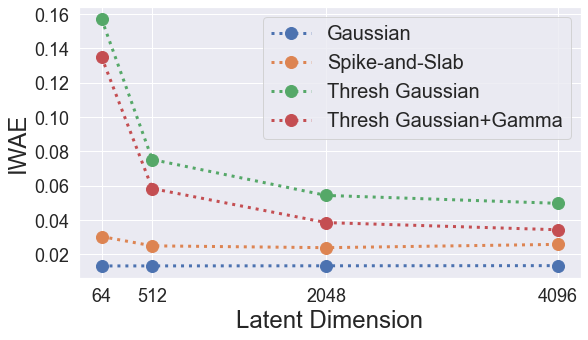

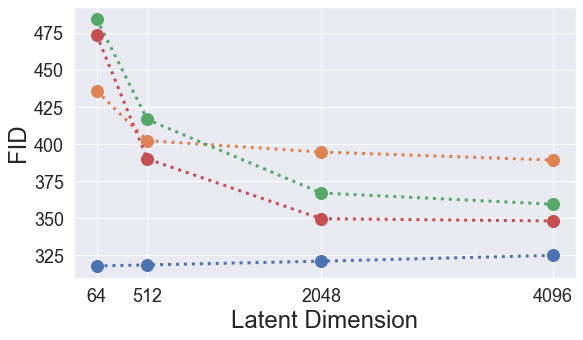

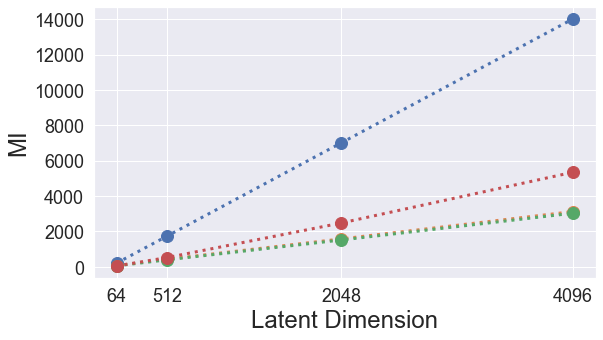

In [9]:
plt.figure(figsize=(9,5))
for idx, label in enumerate(file_labels):
    val = np.array([iwae_dict[label][str(z)] for z in z_list])
    plt.plot(z_list, val, label=label, lw=3, marker="o", ms=12, linestyle="dotted")
plt.ylabel("IWAE", fontsize=24)
plt.xlabel("Latent Dimension", fontsize=24)
plt.xticks(z_list, z_list, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=20)

plt.figure(figsize=(9,5))
for idx, label in enumerate(file_labels):
    val = np.array([fid[label][str(z)] for z in z_list])
    plt.plot(z_list, val, label=label, lw=3, marker="o", ms=12, linestyle="dotted")
plt.ylabel("FID", fontsize=24)
plt.xlabel("Latent Dimension", fontsize=24)
plt.xticks(z_list, z_list, fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=18)

plt.figure(figsize=(9,5))
for idx, label in enumerate(file_labels):
    val = np.array([multi_info[label][str(z)] for z in z_list])
    plt.plot(z_list, val, label=label, lw=3, marker="o", ms=12, linestyle="dotted")
plt.ylabel("MI", fontsize=24)
plt.xlabel("Latent Dimension", fontsize=24)
plt.xticks(z_list, z_list, fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=18)
